# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

Энтропийная функция:

$\psi(x) = \sum \limits_1^d x_i \log x_i$.

Тогда выражение для дивергенции Брегмана имеет вид:

$V(x, y) = \sum \limits_1^d x_i \log x_i - \sum \limits_1^d y_i \log y_i - \sum \limits_1^d (\log x_i + 1)(x_i - y_i) = \sum \limits_1^d x_i \log \dfrac{x_i}{y_i}$.

Итерация метода зеркального спуска:

$x^{k+1} = \arg \underset{x \in C}{\min} \left(\gamma \langle\nabla f(x^k), x\rangle + V(x, x^k) \right) = \arg \underset{x \in \triangle_d}{\min} \left(\gamma \langle\nabla f(x^k), x\rangle + \sum \limits_1^d x_i \log \dfrac{x_i}{x^k_i}\right).$

$\nabla f(x) = \dfrac{A + A^T}{2}x = Ax,$ если $A$ - симметричная.

Тогда шаг метода можем записать следующим образом:

$x^{k+1} = \dfrac{\sum \limits_1^d x_i^k \exp(-\gamma(Ax^k)_i) \cdot e_i}{\sum \limits_1^d x_i^k \exp(-\gamma(Ax^k)_i)},$ где $\{e_i\}_i^d$ $-$ базис в $\mathbb{R}^d$.

In [244]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time

from numba import jit
import warnings
warnings.filterwarnings("ignore")

def generate(d = 3, m = 1, L = 5):

    if d == 1 and m == L:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]
        
    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    return A

In [245]:
L = 50
mu = 1
d = 20

A = generate(d, mu, L)

In [246]:
@jit
def f(x):
    return 0.5 * x.T @ A @ x

@jit
def grad(x):
    return A @ x

@jit
def step(x, gamma):
    y = [x[i] * math.exp(-gamma * (A @ x)[i]) for i in range(d)]
    return y/sum(y)

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Перепишем выражение для критерия:

$$\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle =
​​​​​​​\langle \nabla f(x^k), x^k \rangle
+\max_{y \in \triangle_d} \langle \nabla f(x^k), - y \rangle$$

Имеем задачу линейного программирования с бюджетным множеством в виде симплекса. Как известно, решение такой задачи находится на его вершинах:

$$\text{gap}(x^k) = \langle \nabla f(x^k), x^k \rangle - \min_i \left( \nabla f(x^k) \right)_i$$

Перепишем для нашей задачи, учитывая то, что $A - $ симметричная:

$$\text{gap}(x^k) = \langle Ax^k, x^k \rangle - \min_i \left( Ax^k \right)_i$$

In [247]:
def gap(x):
    g = grad(x).T @ x - np.min(grad(x))
    return g

In [248]:
# 0.005 = 1 / (2 * 100) = 1 / 2L
def mirror_descent(gamma=0.005, iters=2000):

    x = np.random.uniform(low=0, high=1, size=(d,))
    x = x / sum(x)
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    gaps = [gap(x)]
    start = time.time()

    for i in range(1, iters):
        x = step(x, gamma=gamma)
        x_vals.append(x)
        f_vals.append(f(x))
        gaps.append(gap(x))
        times.append(time.time() - start)

    return x_vals, f_vals, times, gaps

In [265]:
iters=3000
x1, f1, times1, gaps1 = mirror_descent(iters=iters)

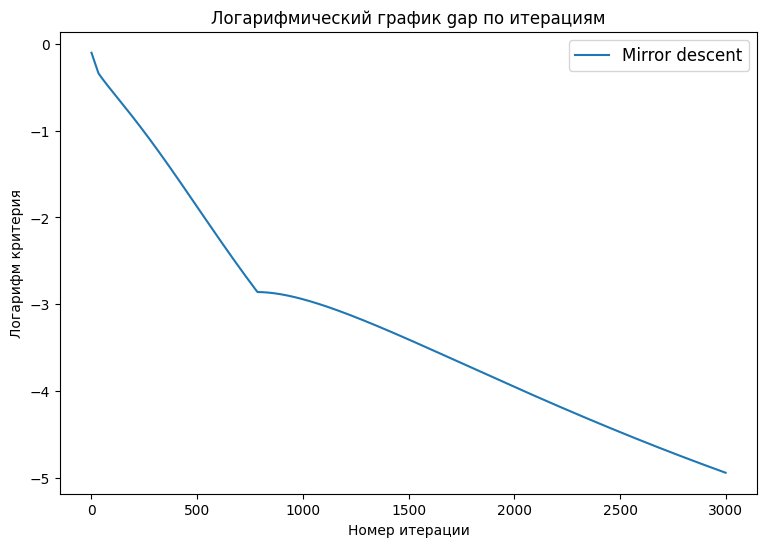

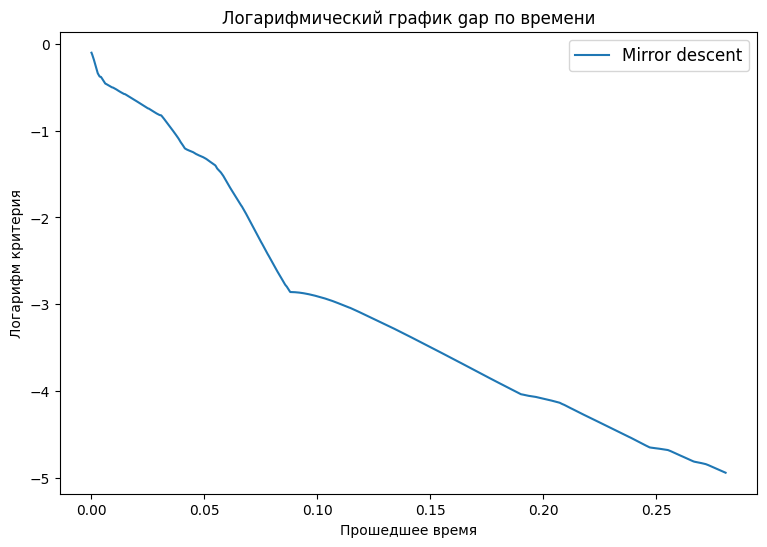

In [266]:
def risovach(times, gaps, labels):

    plt.figure(figsize=(9, 6))
    for g, l in zip(gaps, labels):
        plt.plot(range(len(g)), np.log(g), label=l)
    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.title('Логарифмический график gap по итерациям')
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize=(9, 6))
    for t, g, l in zip(times, gaps, labels):
        plt.plot(t, np.log(g), label=l)
    plt.xlabel("Прошедшее время")
    plt.ylabel("Логарифм критерия")
    plt.title('Логарифмический график gap по времени')
    plt.legend(fontsize=12)
    plt.show()

risovach(times=[times1], gaps=[gaps1], labels=['Mirror descent'])

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

Итерация метода:

$$ s^k = \arg \underset{s \in C}{\min} \langle \nabla f(x^k), s - x^k \rangle = \arg \min_{s \in \triangle_d} \langle \nabla f(x^k), s \rangle$$

$$ x^{k+1} = x^k + \gamma^k (s^k - x^k) $$

Поиск $s^k$ сводится к решению задачи $\langle Ax, s-x \rangle \rightarrow \min$.

Поскольку $0 \notin \triangle_d$, минимум функции $\langle \nabla f(x), s - x \rangle$ достигается на одной из вершин симплекса. История та же, что и при вычислении gap.

In [251]:
def s_(x):
    s = np.zeros(len(x))
    g = grad(x)[0]
    j = 0
    for i in range(1, len(x)):
        if grad(x)[i] < g:
            g = grad(x)[i]
            j = i
    s[j] = 1
    return s

# нужен шаг, уменьшающийся с номером итерации
def gamma(k):
    return 1 / (k + 2)

def frank_wolfe(iters=2000):

    x = np.random.uniform(low=0, high=1, size=(d,))
    x = x / sum(x)

    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    gaps = [gap(x)]

    start_time = time.time()

    for i in range(1, iters):

        x = x + gamma(i) * (s_(x) - x)
        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start_time)
        gaps.append(gap(x))

    return x_vals, f_vals, times, gaps

In [252]:
x2, f2, times2, gaps2 = frank_wolfe(iters=iters)

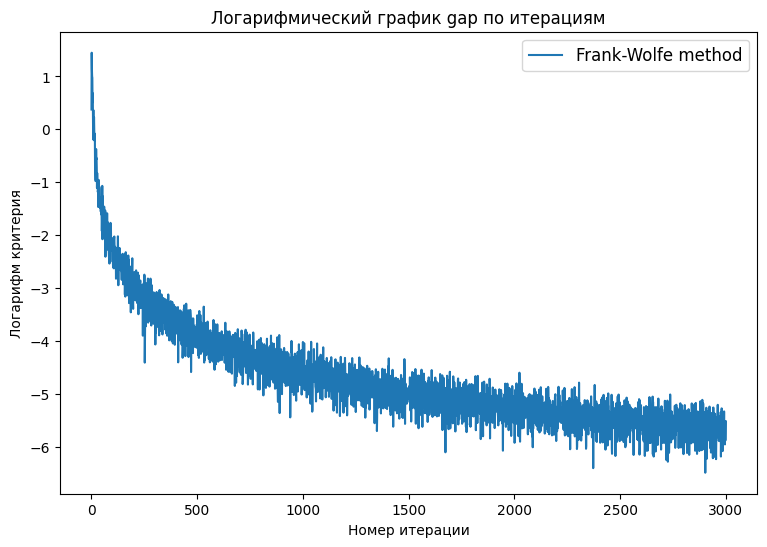

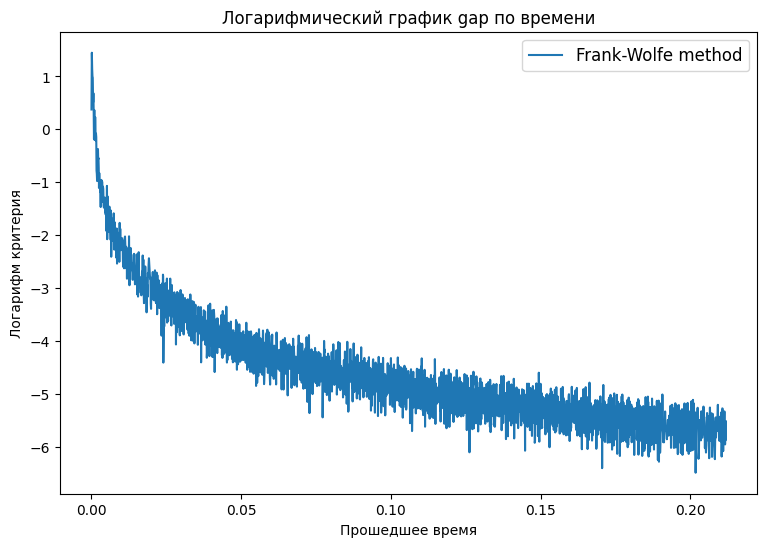

In [253]:
risovach(times=[times2], gaps=[gaps2], labels=['Frank-Wolfe method'])

Из-за того что метод прыгает по вершинам симплекса, график сходимости осциллирует. Сравним метод Франка-Вульфа с зеркальным спуском.

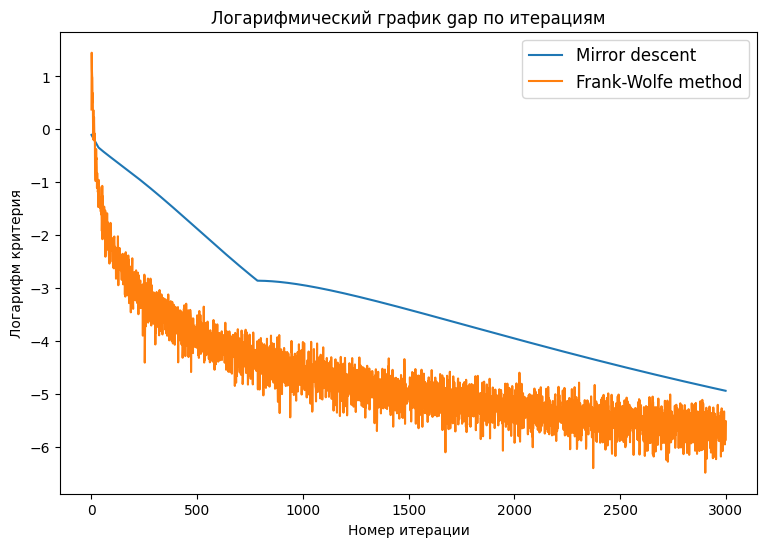

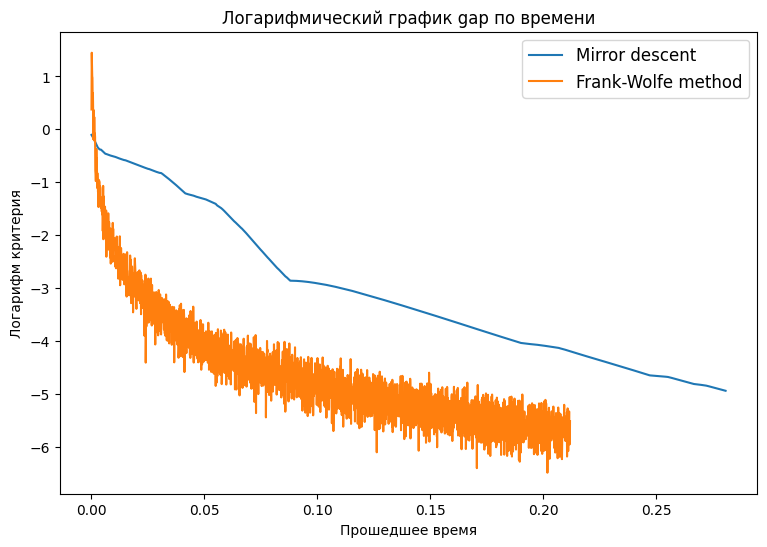

In [267]:
risovach(times=[times1, times2], gaps=[gaps1, gaps2], labels=['Mirror descent', 'Frank-Wolfe method'])

В среднем метод Франка-Вульфа и сходится получше, и работает чуть быстрее.

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

Метод проекций:

$$x^{k + 1} = \text{proj}_{\triangle_d} (x^k - \gamma \nabla (x^k))$$

$$\text{proj}_{\triangle_d} (x) = \arg \min_{y \in \triangle_d} \left( \frac{1}{2} \| y - x \|_2^2 \right)$$

In [255]:
# проекция на вероятностный симплекс
def proj(x):
    x_sort = sorted(x, reverse=True)
    rho = 0
    s = x_sort[0]
    s_ans = s

    for i in range(1, len(x_sort)):
        s += x_sort[i]
        if x_sort[i] + 1 / (i + 1) * (1 - s) > 0:
            rho = i
            s_ans = s

    l = 1 / (rho + 1) * (1 - s_ans)
    ans = np.zeros(len(x_sort))
    for i in range(len(ans)):
        ans[i] = max(x[i] + l, 0)
    return ans

In [256]:
def grad_descent_proj(gamma=0.005, iters=2000):

    x = np.random.uniform(low=0, high=1, size=(d,))
    x = x / sum(x)
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    gaps = [gap(x)]

    start = time.time()

    for i in range(1, iters):
        x = proj(x - gamma * grad(x))
        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        gaps.append(gap(x))

    return x_vals, f_vals, times, gaps

In [257]:
x3, f3, times3, gaps3 = grad_descent_proj(iters=iters)

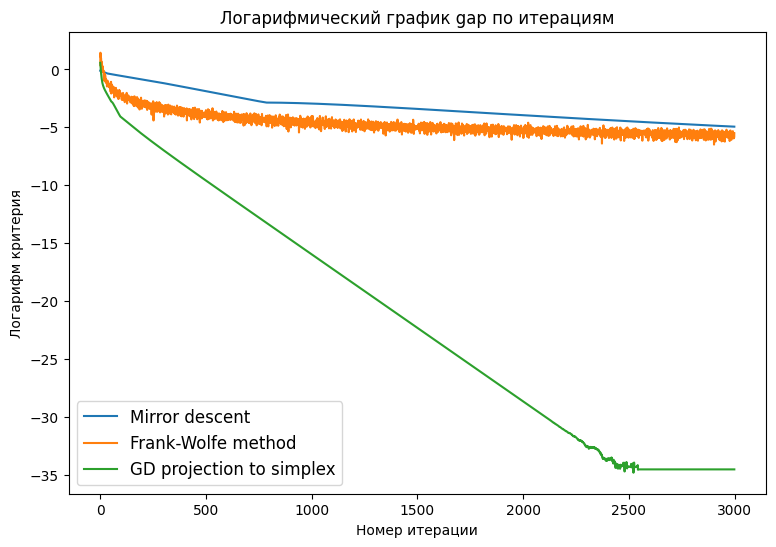

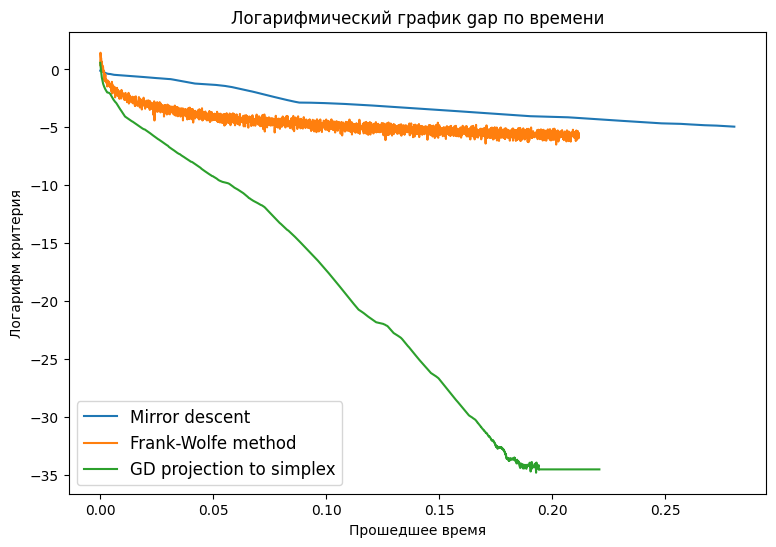

In [268]:
risovach(times=[times1, times2, times3], gaps=[gaps1, gaps2, gaps3], labels=['Mirror descent', 'Frank-Wolfe method', 'GD projection to simplex'])

Градиентный спуск с проекцией на вероятностный симплекс показал намного более высокую точность по критерию gap, чем рассмотренные выше методы. Время его работы близко к времени работы метода Франка-Вульфа.

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [259]:
# optimal parameters for algorithm 2

x_0 = np.random.uniform(low=0, high=1, size=(d,))
p_0 = x_0 / np.linalg.norm(x_0, ord=1)
p_0[1] = 1
delta = f(p_0)
N = math.ceil(2 * math.sqrt(6 * L / mu))

def beta(k):
    return 2 * L / k

def gamma(k):
    return 2 / (k + 1)

def eta(s, k):
    return 8 * L * delta * 2**(-s) / (mu * N * k)

In [260]:
def CndG(g, u, beta, et):
    u_now = u
    while True:

        v = np.zeros(len(u))
        minimum = (g + beta * (u_now - u))[0]
        j = 0
        for i in range(1, len(u)):
            if (g + beta * (u_now - u))[i] < minimum:
                minimum = (g + beta * (u_now - u))[i]
                j = i
        v[j] = 1

        W = (g + beta * (u_now - u)).T @ u_now - np.min(g + beta * (u_now - u))

        if W <= et:
            return u_now
        
        alpha = min(1, ((beta * (u - u_now) - g).T @ (v - u_now)) / (beta * np.linalg.norm(v - u_now, ord=2)**2))
        u_now = (1 - alpha) * u_now + alpha * v

In [261]:
# algorithm 1
# s - 1st param for eta
def frank_wolfe_fast(p_0, beta, gamma, s, iters=2000):

    x_now = p_0
    y_now = x_now

    times = [0.]
    gaps = [gap(x_now)]
    
    start = time.time()
    
    for k in range(1, iters):
        z = (1 - gamma(k)) * y_now + gamma(k) * x_now
        x = CndG(grad(z), x_now, beta(k), eta(s, k))
        y = (1 - gamma(k)) * y_now + gamma(k) * x
        x_now = x
        y_now = y

        times.append(time.time() - start)
        gaps.append(gap(x))

    return x_now, times, gaps

In [262]:
print(N)

# algorithm 2
def frank_wolfe_fast_strong(p_0, beta, gamma, iters=10):
    p_now = p_0
    times = [0.]
    gaps = [gap(p_now)]
    
    start_time = time.time()

    for s in range(1, iters):
        process_time = time.time()
        p_now, tmp_times, tmp_gap = frank_wolfe_fast(p_now, beta, gamma, s, N)
        gaps += tmp_gap

        tmp_times = list(map(lambda time: process_time + time - start_time, tmp_times))
        times += tmp_times

    return p_now, times, gaps

35


In [275]:
_, times4, gaps4 = frank_wolfe_fast_strong(p_0, beta, gamma, iters=14) 

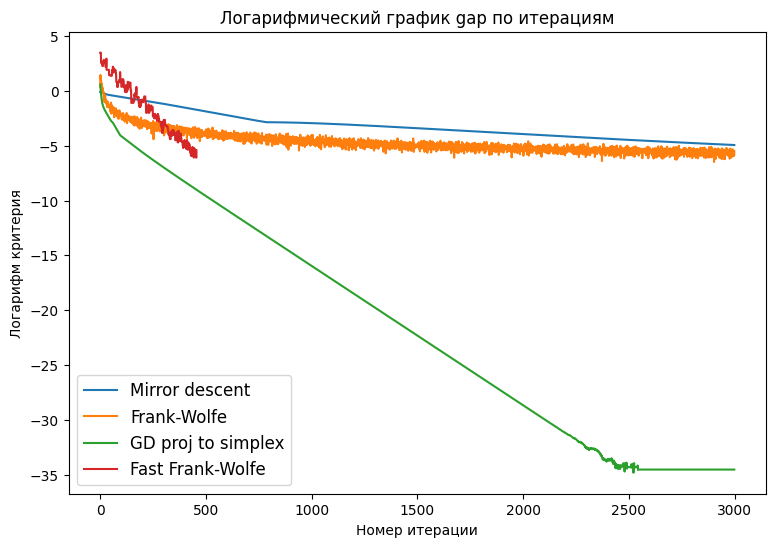

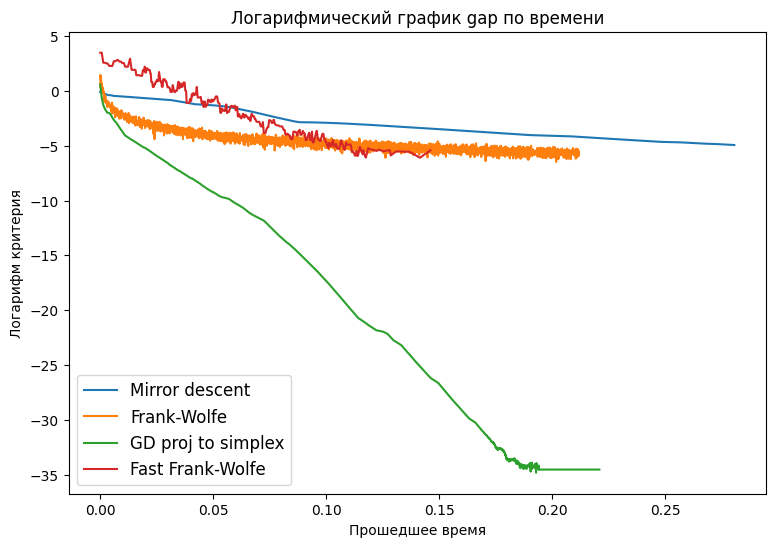

In [276]:
risovach(times=[times1, times2, times3, times4], gaps=[gaps1, gaps2, gaps3, gaps4], labels=['Mirror descent', 'Frank-Wolfe', 'GD proj to simplex','Fast Frank-Wolfe'])

Видим, что градиентный спуск с проекцией показывает лучшие результы. Ускоренный метод Франка-Вульфа работает быстрее зеркального спуска и обычного метода Франка-Вульфа, но стоимость одной его итерации заметно выше. 